In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_batch_size = 100    #每批处理的训练集数据
test_batch_size = 100     #每批处理的测试集数据
learning_rate = 0.001     #学习率
num_epoches = 50          #训练数据集的轮次

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),                                               # 归一化
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # 标准化
])

In [4]:
train_valid_cifar10 = torchvision.datasets.CIFAR10(
    root='datasets',
    train=True,
    download=True,
    transform=transform
)
test_cifar10 = torchvision.datasets.CIFAR10(
    root='datasets',
    train=False,
    download=True,
    transform=transform
)
print(train_valid_cifar10)
print(test_cifar10)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [5]:
#分割数据集
lengths = [5000,len(train_valid_cifar10)-5000]
valid_cifar10, train_cifar10 = torch.utils.data.random_split(train_valid_cifar10,lengths,generator=torch.Generator().manual_seed(0))

In [6]:
#训练集
train_loader = torch.utils.data.DataLoader(train_cifar10, batch_size=train_batch_size, shuffle=True)
#验证集
valid_loader = torch.utils.data.DataLoader(valid_cifar10, batch_size=train_batch_size, shuffle=True)
#测试集
test_loader = torch.utils.data.DataLoader(test_cifar10, batch_size=test_batch_size, shuffle=False)

In [7]:
test_loader.dataset[0][0].shape

torch.Size([3, 32, 32])

In [25]:
def out(w,k,s,p):
    return (w-k+2*p)/s+1
out(8,3,1,0)

6.0

In [26]:
class Net(nn.Module):
    def __init__(self,num_classes=10):
        super(Net,self).__init__()
        self.features = nn.Sequential(  #打包
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),      # input[6, 32, 32]  output[16, 32, 32] 
            nn.ReLU(inplace=True),      
            nn.MaxPool2d(kernel_size=2),                              # output[16, 16, 16] 
            nn.Conv2d(16, 48, kernel_size=3, stride=1, padding=1),     # output[48, 16, 16]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                              # output[16, 8, 8]
            nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=0),    # output[96, 6, 6]
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(96*6*6,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,128),
            nn.ReLU(inplace=True),
            nn.Linear(128,num_classes),
        )
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1) 
        x = self.classifier(x)
        return x
        

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model = model.to(device)
print(model)

Net(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3456, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [28]:
# 损失器
criterion = nn.CrossEntropyLoss()
# 优化器
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0) 

In [29]:
train_loss = []        
valid_loss = []  
test_loss = []
train_acc  = []    
valid_acc = [] 
test_acc  = []     

In [30]:
for epoch in range(num_epoches):
    print('epoch:',epoch+1)

    model.train()
    for _,data in enumerate(train_loader,0):
        inputs, labels = data[0],data[1]
        inputs = inputs.view(train_batch_size, -1, 32, 32)  
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # 每次训练梯度清零
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    model.eval()
    running_loss = 0.0
    correct = 0             
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(train_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 32, 32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    train_loss.append(running_loss/total)
    train_acc.append(correct / total)
    print("训练集上的损失：%.3f" % (running_loss / total))
    print("训练集上的准确率：%.3f" % (correct / total))


    model.eval()
    running_loss = 0.0
    correct = 0             
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(valid_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 32, 32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    valid_loss.append(running_loss / total)
    valid_acc.append(correct / total)
    print("验证集上的损失：%.3f" % (running_loss / total))
    print("验证集上的准确率：%.3f" % (correct / total))
    
    
    model.eval()
    running_loss = 0.0
    correct = 0            
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(test_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 32, 32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    test_loss.append(running_loss / total)
    test_acc.append(correct / total)
    print("测试集上的损失：%.3f" % (running_loss / total))
    print("测试集上的准确率：%.3f" % (correct / total))

epoch: 1
训练集上的损失：0.023
训练集上的准确率：0.239
验证集上的损失：0.023
验证集上的准确率：0.234
测试集上的损失：0.023
测试集上的准确率：0.235
epoch: 2
训练集上的损失：0.019
训练集上的准确率：0.304
验证集上的损失：0.019
验证集上的准确率：0.302
测试集上的损失：0.019
测试集上的准确率：0.306
epoch: 3
训练集上的损失：0.018
训练集上的准确率：0.367
验证集上的损失：0.018
验证集上的准确率：0.356
测试集上的损失：0.017
测试集上的准确率：0.373
epoch: 4
训练集上的损失：0.016
训练集上的准确率：0.432
验证集上的损失：0.016
验证集上的准确率：0.422
测试集上的损失：0.016
测试集上的准确率：0.429
epoch: 5
训练集上的损失：0.015
训练集上的准确率：0.472
验证集上的损失：0.015
验证集上的准确率：0.458
测试集上的损失：0.015
测试集上的准确率：0.472
epoch: 6
训练集上的损失：0.014
训练集上的准确率：0.506
验证集上的损失：0.014
验证集上的准确率：0.492
测试集上的损失：0.014
测试集上的准确率：0.502
epoch: 7
训练集上的损失：0.013
训练集上的准确率：0.533
验证集上的损失：0.013
验证集上的准确率：0.513
测试集上的损失：0.013
测试集上的准确率：0.530
epoch: 8
训练集上的损失：0.013
训练集上的准确率：0.553
验证集上的损失：0.013
验证集上的准确率：0.533
测试集上的损失：0.013
测试集上的准确率：0.547
epoch: 9
训练集上的损失：0.012
训练集上的准确率：0.569
验证集上的损失：0.013
验证集上的准确率：0.550
测试集上的损失：0.013
测试集上的准确率：0.559
epoch: 10
训练集上的损失：0.012
训练集上的准确率：0.595
验证集上的损失：0.012
验证集上的准确率：0.573
测试集上的损失：0.012
测试集上的准确率：0.578
epoch: 11
训练集上的损失：0.011
训练集上的准确率：0.616


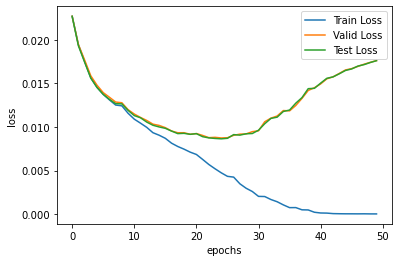

In [31]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(len(train_loss)), train_loss)
plt.plot(np.arange(len(valid_loss)), valid_loss)
plt.plot(np.arange(len(test_loss)), test_loss)
plt.legend(['Train Loss','Valid Loss','Test Loss'])

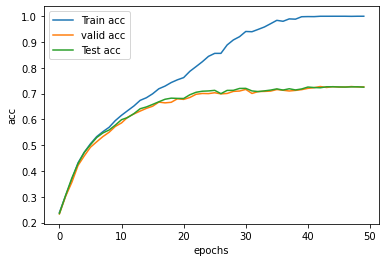

In [32]:
#准确率
plt.xlabel('epochs')
plt.ylabel('acc')
plt.plot(np.arange(len(train_acc)), train_acc)
plt.plot(np.arange(len(valid_acc)), valid_acc)
plt.plot(np.arange(len(test_acc)), test_acc)
plt.legend(['Train acc','valid acc','Test acc'])

In [37]:
print('验证集最高准确率: ', max(valid_acc), '\t索引:', valid_acc.index(max(valid_acc)))
print('测试集最高准确率: ', max(test_acc), '\t索引:',test_acc.index(max(test_acc)))

验证集最高准确率:  0.7276 	索引: 42
测试集最高准确率:  0.7265 	索引: 43


In [41]:
pos = valid_acc.index(max(valid_acc))
print('验证集最高准确率的模型对应的测试集准确率：', test_acc[pos], '\t索引:', pos)

验证集最高准确率的模型对应的测试集准确率： 0.7227 	索引: 42
